In [ ]:
!curl -O http://ufldl.stanford.edu/housenumbers/train_32x32.mat

In [ ]:
!curl -O http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [17]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import io

In [8]:
train_data = io.loadmat('train_32x32.mat')

In [9]:
test_data = io.loadmat('test_32x32.mat')

In [10]:
train_X = train_data['X']
train_Y= train_data['y']

In [11]:
train_X

array([[[[ 33,  84,  19, ...,  92, 190, 216],
         [ 30,  76,  54, ...,  78, 188, 217],
         [ 38,  59, 110, ..., 101, 191, 212]],

        [[ 15,  86,  20, ...,  94, 205, 221],
         [ 23,  73,  52, ...,  82, 203, 222],
         [ 19,  66, 111, ..., 105, 206, 217]],

        [[ 15,  77,  25, ..., 114, 220, 226],
         [ 17,  78,  57, ..., 101, 218, 227],
         [ 19,  56, 116, ..., 125, 220, 221]],

        ...,

        [[ 72,  90,  65, ..., 200, 229, 200],
         [ 65,  78, 144, ..., 201, 231, 199],
         [ 56,  69, 223, ..., 203, 224, 191]],

        [[ 82,  88,  78, ..., 192, 229, 193],
         [ 77,  77, 148, ..., 193, 229, 188],
         [ 57,  67, 218, ..., 195, 224, 182]],

        [[ 89,  88,  98, ..., 190, 229, 197],
         [ 79,  78, 158, ..., 191, 228, 189],
         [ 59,  66, 220, ..., 193, 223, 186]]],


       [[[ 28,  85,  21, ...,  92, 183, 204],
         [ 39,  77,  53, ...,  78, 182, 205],
         [ 35,  61, 110, ..., 103, 186, 202]],

    

In [12]:
train_X.shape

(32, 32, 3, 73257)

In [41]:
train_X[:, :, :, 0]

array([[[ 33,  30,  38],
        [ 15,  23,  19],
        [ 15,  17,  19],
        ...,
        [ 72,  65,  56],
        [ 82,  77,  57],
        [ 89,  79,  59]],

       [[ 28,  39,  35],
        [ 14,  25,  22],
        [ 14,  20,  17],
        ...,
        [ 40,  39,  50],
        [ 67,  58,  52],
        [ 83,  78,  60]],

       [[ 40,  41,  38],
        [ 18,  21,  26],
        [ 16,  17,  23],
        ...,
        [ 23,  29,  45],
        [ 35,  42,  44],
        [ 72,  69,  53]],

       ...,

       [[ 86,  81,  75],
        [ 87,  82,  71],
        [ 82,  79,  65],
        ...,
        [104, 104,  87],
        [104, 105,  81],
        [103, 105,  78]],

       [[ 84,  86,  64],
        [ 86,  79,  72],
        [ 82,  76,  72],
        ...,
        [110, 103,  84],
        [106, 105,  85],
        [106, 104,  86]],

       [[ 85,  88,  68],
        [ 89,  82,  72],
        [ 85,  79,  67],
        ...,
        [111, 104,  87],
        [109, 105,  86],
        [103, 106,  79]]

In [39]:
train_Y

array([[1],
       [9],
       [2],
       ...,
       [1],
       [6],
       [9]], dtype=uint8)

In [15]:
train_X_reshaped = train_X.transpose(3, 0, 1, 2).reshape(73257, 32*32*3)


In [42]:
train_X_reshaped.shape

(73257, 3072)

In [44]:
train_X_reshaped[0, :][:10]

array([33, 30, 38, 15, 23, 19, 15, 17, 19, 42], dtype=uint8)

In [16]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X_reshaped)


In [18]:
pca = PCA(n_components=0.9)
train_X_pca = pca.fit_transform(train_X_scaled)

n_components = pca.n_components_


In [19]:
n_components

26

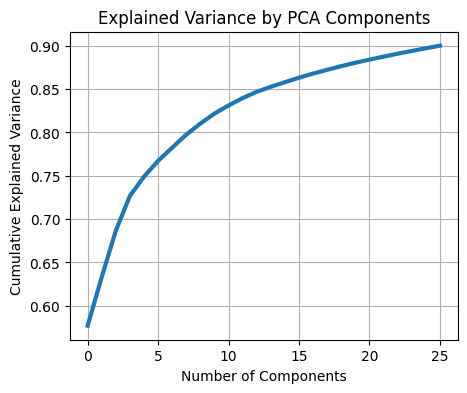

In [47]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(5, 4))
plt.plot(cumulative_variance, lw=3)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


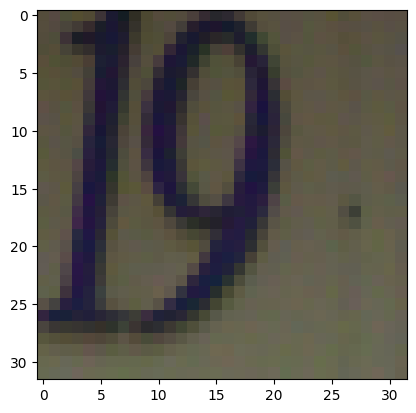

In [33]:
plt.imshow(train_X[:,:,:,1])

In [48]:
pca.explained_variance_ratio_

array([0.57702068, 0.05612676, 0.05356865, 0.04007071, 0.0222249 ,
       0.01819314, 0.01524493, 0.0150657 , 0.01273919, 0.01149399,
       0.0094194 , 0.0084684 , 0.00728761, 0.00571811, 0.00535732,
       0.00512879, 0.00479845, 0.00432683, 0.00424142, 0.00390777,
       0.00360457, 0.00345771, 0.00336561, 0.00315328, 0.00308502,
       0.00298371])